In [1]:
####importing packages
import sys
sys.path.append('/work/mh0731/m300876/package')
import interp3d
import icons
from pathlib import Path
import importlib
import numpy as np
import xarray as xr
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources\

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
import dask # Distributed data libary

In [3]:
icons.prepare_cpu(memory='128GB',nworker=1)

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300876/levante-spawner-advanced//proxy/41591/status,
Dashboard: /user/m300876/levante-spawner-advanced//proxy/41591/status,Workers: 1
Total threads: 256,Total memory: 119.21 GiB
Status: running,Using processes: False
Comm: inproc://136.172.116.115/2102787/1,Workers: 1
Dashboard: /user/m300876/levante-spawner-advanced//proxy/41591/status,Total threads: 256
Started: Just now,Total memory: 119.21 GiB
Comm: inproc://136.172.116.115/2102787/4,Total threads: 256
Dashboard: /user/m300876/levante-spawner-advanced//proxy/38895/status,Memory: 119.21 GiB
Nanny: None,


**Interpolate data**

In [4]:
def add_coord_var(darray,gridset):
    clon_x = xr.DataArray(gridset.clon.values,
                      dims=gridset.clon.dims,attrs={k:v for k,v in gridset.clon.attrs.items()})
    clat_y = xr.DataArray(gridset.clat.values,
                      dims=gridset.clat.dims,attrs={k:v for k,v in gridset.clat.attrs.items()})
    dset = darray.rename({'ncells':'cell'}).assign_coords(clon=clon_x,clat=clat_y).to_dataset()
    dset['clon_vertices'] = gridset.clon_vertices 
    dset['clat_vertices'] = gridset.clat_vertices 
    return dset

In [5]:
def cut_gridset(grid_file,x_first,y_first,x_end,y_end):
    gridset = xr.open_dataset(grid_file,chunks='auto')
    factor = 1/180*np.pi
    return gridset.where(((gridset.clon>(x_first*factor)) & (gridset.clon<(x_end*factor))) & (
        (gridset.clat>(y_first*factor)) & (gridset.clat<(y_end*factor))),drop=True) 

In [6]:
def interp_data(darray, x_res, y_res,x_first,y_first,x_end,y_end,grid_file,weights=None):
    gridset = cut_gridset(grid_file,x_first,y_first,x_end,y_end)
    dset= add_coord_var(darray,gridset)
    ###interpolation
    remap_var = interp3d.remap_cut(dset, x_res, y_res,x_first,y_first,x_end,y_end,grid_file)
    remap_jobs = dask.persist(remap_var)
    progress(remap_jobs, notebook=False)
    var_final = dask.compute(remap_var)
    return var_final[0]

**ngc2002**

In [7]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'atm_2d_ml'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/bm1235/k203123/experiments/ngc2002')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
files02 = sorted([str(f) for f in data_path1.glob(f'run*/*{glob_pattern_3d1}*.nc')])[:]

In [8]:
grid_file = '/pool/data/ICON/grids/public/mpim/0015/icon_grid_0015_R02B09_G.nc'

__netcdf4__

In [10]:
%time vas01 = icons.temporal_mean(files02,'netcdf','vas',['2020-03-01','2020-05-14'],[-20,20],\
                                 [-70,20],mask=None,better_time=False)

CPU times: user 4min 12s, sys: 3min 16s, total: 7min 29sted |  5min 32.4s
Wall time: 6min 9s


In [11]:
%time uas01 = icons.temporal_mean(files02,'netcdf','uas',['2020-03-01','2020-05-14'],[-20,20],\
                                 [-70,20],mask=None,better_time=False)

CPU times: user 3min 58s, sys: 3min 21s, total: 7min 19sted |  5min  1.7s
Wall time: 5min 37s


**interpolation of data**

In [12]:
%time vas01_interp = interp_data(vas01,0.1,0.1,-70,-20,20,20,grid_file,weights=None)

CPU times: user 9.55 s, sys: 4.87 s, total: 14.4 sCompleted | 27.7s
Wall time: 34.9 s


In [13]:
%time uas01_interp = interp_data(uas01,0.1,0.1,-70,-20,20,20,grid_file,weights=None)

CPU times: user 9.04 s, sys: 4.79 s, total: 13.8 sCompleted | 27.1s
Wall time: 34.2 s


In [14]:
from cartopy import crs as ccrs # Cartography library
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import pyplot as plt # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

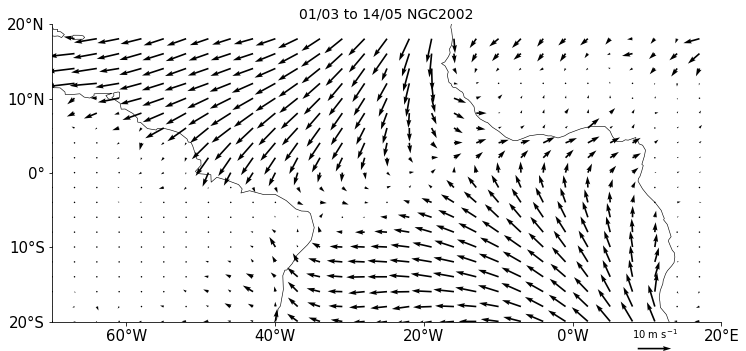

In [73]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
Q = plt.quiver(
    uas01_interp.lon[::30],uas01_interp.lat[::20],uas01_interp.uas.squeeze().data[::20,::30],
    vas01_interp.vas.squeeze().data[::20,::30],
scale=200)
qv = plt.quiverkey(Q, 0.9, -0.09, 10, label='10 m s$^{-1}$')
ax.set_title('01/03 to 14/05 NGC2002',fontsize=14)
ax.coastlines(resolution='110m',linewidth=0.6)
ax.set_extent([-70,20,-20,20], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,21,10),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-60, 21,20),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_ylabel(None);ax.set_xlabel(None);ax.tick_params(labelsize=15)
ax.outline_patch.set_visible(False)
ax.spines.left.set_visible(True)
ax.spines.bottom.set_visible(True)
plt.savefig('/scratch/m/m300876/results/atlantic_itcz/ngc2002_winds10m_03_01_05_14.png',
            dpi=400,format='png',\
            bbox_inches='tight',orientation={'landscape'})

**ngc2006**

In [47]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'atm_2d_ml'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/bm1235/k203123/experiments/ngc2006')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
files06 = sorted([str(f) for f in data_path1.glob(f'run*/*{glob_pattern_3d1}*.nc')])[:]

In [48]:
grid_file = '/pool/data/ICON/grids/public/mpim/0015/icon_grid_0015_R02B09_G.nc'

__netcdf4__

In [49]:
%time uas06 = icons.temporal_mean(files06,'netcdf','uas',['2020-03-01','2020-05-14'],[-20,20],\
                                 [-70,20],mask=None,better_time=False)

CPU times: user 4min 17s, sys: 3min 21s, total: 7min 38sted |  5min 19.1s
Wall time: 6min 10s


In [50]:
%time vas06 = icons.temporal_mean(files06,'netcdf','vas',['2020-03-01','2020-05-14'],[-20,20],\
                                 [-70,20],mask=None,better_time=False)

CPU times: user 4min 21s, sys: 3min 18s, total: 7min 40sted |  5min 29.6s
Wall time: 6min 16s


**interpolation of data**

In [51]:
%time uas06_interp = interp_data(uas06,0.1,0.1,-70,-20,20,20,grid_file,weights=None)

CPU times: user 9.34 s, sys: 3.77 s, total: 13.1 sCompleted | 26.1s
Wall time: 33.7 s


In [52]:
%time vas06_interp = interp_data(vas06,0.1,0.1,-70,-20,20,20,grid_file,weights=None)

CPU times: user 9.16 s, sys: 3.85 s, total: 13 s% Completed | 26.1s
Wall time: 33.4 s


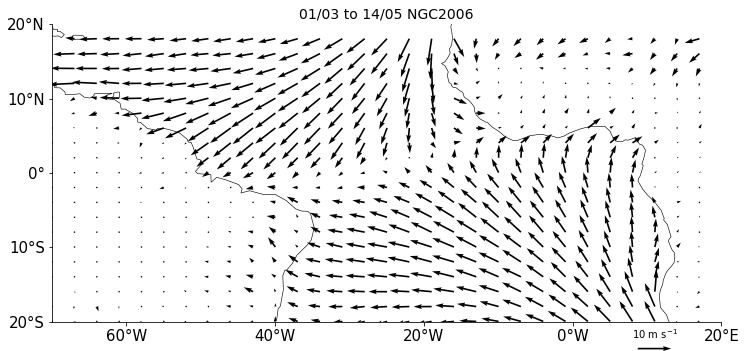

In [70]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
Q = plt.quiver(
    uas06_interp.lon[::30],uas06_interp.lat[::20],uas06_interp.uas.squeeze().data[::20,::30],
    vas06_interp.vas.squeeze().data[::20,::30],
scale=200)
qv = plt.quiverkey(Q, 0.9, -0.09, 10, label='10 m s$^{-1}$')
ax.set_title('01/03 to 14/05 NGC2006',fontsize=14)
ax.coastlines(resolution='110m',linewidth=0.6)
ax.set_extent([-70,20,-20,20], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,21,10),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-60, 21,20),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_ylabel(None);ax.set_xlabel(None);ax.tick_params(labelsize=15)
ax.outline_patch.set_visible(False)
ax.spines.left.set_visible(True)
ax.spines.bottom.set_visible(True)
plt.savefig('/scratch/m/m300876/results/atlantic_itcz/ngc2006_winds10m_03_01_05_14.png',
            dpi=400,format='png',\
            bbox_inches='tight',orientation={'landscape'})

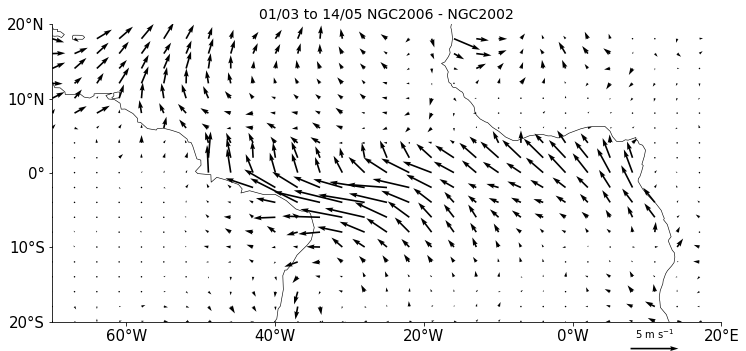

In [72]:
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
Q = plt.quiver(
    uas01_interp.lon[::30],uas01_interp.lat[::20],
    uas06_interp.uas.squeeze().data[::20,::30] - uas01_interp.uas.squeeze().data[::20,::30],
    vas06_interp.vas.squeeze().data[::20,::30] - vas01_interp.vas.squeeze().data[::20,::30],
scale=70)
qv = plt.quiverkey(Q, 0.9, -0.09, 5, label='5 m s$^{-1}$')
ax.set_title('01/03 to 14/05 NGC2006 - NGC2002',fontsize=14)
ax.coastlines(resolution='110m',linewidth=0.6)
ax.set_extent([-70,20,-20,20], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,21,10),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-60, 21,20),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_ylabel(None);ax.set_xlabel(None);ax.tick_params(labelsize=15)
ax.outline_patch.set_visible(False)
ax.spines.left.set_visible(True)
ax.spines.bottom.set_visible(True)
plt.savefig('/scratch/m/m300876/results/atlantic_itcz/ngc2006_minus_ngc2002_winds10m_03_01_05_14.png',
            dpi=400,format='png',\
            bbox_inches='tight',orientation={'landscape'})

_Calculate clim mean for certain period_

In [21]:
def annual_mean_sel(dset,years,dates):
    pr = dset.sel(time=slice(str(years)+dates[0],str(years)+dates[1])).groupby("time.year").mean(dim='time')
    return pr

In [22]:
def time_mean_imerg_multi(file,dates,lon,lat):
    dset1 = xr.open_mfdataset(file, combine='by_coords',engine='netcdf4')['calibrated_precipitation']
    pr=dset1.sel(lat=slice(lat[0],lat[1]),lon=slice(lon[0],lon[1]))

    years = np.unique(pr['time.year'])
    annual_mean = np.zeros((years.size,pr.shape[1],pr.shape[2]))
    for t in range(years.size):
        pr1 = annual_mean_sel(pr,years[t],dates)
        jobs = dask.persist(pr1)
        progress(jobs, notebook=False)
        precip = dask.compute(pr1)
        if t == 0:
            precipf = precip[0]
        else:
            precipf = xr.concat([precipf,precip[0]],dim='year')    
        precip_mean = precipf.mean(dim=('year'),skipna=True) 
    return precip_mean

In [23]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'IMERG_precipitationrate_V06B_daily_0.1degree_tropics_30S_30N_'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/from_Mistral/mh0731/m300876/precip_paper/data/obs/IMERG')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
file_imerg = sorted([str(f) for f in data_path1.rglob(f'*{glob_pattern_3d1}*.nc')])[:]

In [24]:
imerg_multi_mam= time_mean_imerg_multi(file_imerg[:-2],['-03-01','-05-14'],[-70,20],[-20,20])

In [25]:
imerg_multi_mam_inter = imerg_multi_mam.interp(lon=pr_interp.lon.values,lat=pr_interp.lat.values,method='linear')

In [28]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, BoundaryNorm

In [36]:
BrBG2 = cm.get_cmap('BrBG', 14)
newcolors2 = BrBG2(np.linspace(0, 1, 14))
white = np.array([1, 1, 1, 1])
#scnd = np.array([0.89051745, 0.76469402, 0.71028506 , 1])
newcolors2[6, :] = white
newcolors2[7, :] = white
newcolors2[8, :] = white
clevs = [-25, -20, -10, -5, -2, -1, 0, 1, 2, 5,
         10, 20, 25]
BrBG2 = ListedColormap(newcolors2,'precip')
BrBG2_norm = BoundaryNorm(clevs,BrBG2.N)

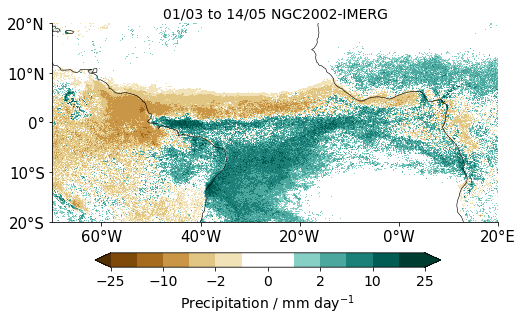

In [42]:
fig = plt.figure(figsize=(8, 4))
ax1=fig.add_axes([0.2,0.0,0.6,0.05])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree())
plot = (pr_interp.pr*24*3600 - imerg_multi_mam_inter).plot(
    ax=ax,
    transform=ccrs.PlateCarree(),
    levels = clevs,
    cmap=BrBG2,
    norm = BrBG2_norm,
    extend='both', add_colorbar=False)
ax.coastlines(resolution='110m',linewidth=0.6)
cb1 = plt.colorbar(plot,extend='both',orientation='horizontal',cax=ax1,shrink=0.8,pad=0.09)
cb1.ax.set_xlabel('Precipitation / mm day$^{-1}$',fontsize=14)
cb1.ax.tick_params(labelsize=14)

ax.set_title('01/03 to 14/05 NGC2002-IMERG',fontsize=14)
ax.set_extent([-70,20,-20,20], crs=ccrs.PlateCarree())
ax.set_yticks(np.arange(-20,21,10),crs=ccrs.PlateCarree())
lat_formatter = LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)
ax.set_xticks(np.arange(-60, 21,20),crs=ccrs.PlateCarree())
lon_formatter = LongitudeFormatter(zero_direction_label=True)
ax.xaxis.set_major_formatter(lon_formatter)
ax.set_ylabel(None);ax.set_xlabel(None);ax.tick_params(labelsize=15)

ax.outline_patch.set_visible(False)
ax.spines.left.set_visible(True)
ax.spines.bottom.set_visible(True)
plt.savefig('/scratch/m/m300876/results/atlantic_itcz/ngc2002_precipitation_bias_imerg_03_01_05_14.png',dpi=400,format='png',\
            bbox_inches='tight',orientation={'landscape'})